## *1. Import Modules and Libraries*


In [1]:
!pip install --upgrade patsy statsmodels seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 73.1 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.2
    Uninstalling statsmodels-0.14.2:
      Successfully uninstalled statsmodels-0.14.2
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


In [2]:
!pip install catboost

In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## *2. Read Dataset*

In [5]:
test_file = "/kaggle/input/playground-series-s4e10/test.csv"
train_file = "/kaggle/input/playground-series-s4e10/train.csv"

In [6]:
train_df = pd.read_csv(train_file, index_col='id')
test_df = pd.read_csv(test_file, index_col='id')

In [8]:
print("Shape of Training file:", train_df.shape)
print("Shape of Testing file:", test_df.shape)

Shape of Training file: (58645, 12)
Shape of Testing file: (39098, 11)


## *3. Analyze Dataset*

In [9]:
print(train_df.head())

    person_age  person_income person_home_ownership  person_emp_length  \
id                                                                       
0           37          35000                  RENT                0.0   
1           22          56000                   OWN                6.0   
2           29          28800                   OWN                8.0   
3           30          70000                  RENT               14.0   
4           22          60000                  RENT                2.0   

   loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
id                                                                         
0    EDUCATION          B       6000          11.49                 0.17   
1      MEDICAL          C       4000          13.35                 0.07   
2     PERSONAL          A       6000           8.90                 0.21   
3      VENTURE          B      12000          11.11                 0.17   
4      MEDICAL          A

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [11]:
num_cols = train_df.select_dtypes(include=['number']).columns
num_cols

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'loan_status'],
      dtype='object')

In [12]:
obj_cols = train_df.select_dtypes(include=['object']).columns
obj_cols

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [13]:
print("Numerical Column description")
for col in num_cols:
  print(f"\n{col}:\n", train_df[col].describe())

Numerical Column description

person_age:
 count    58645.000000
mean        27.550857
std          6.033216
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        123.000000
Name: person_age, dtype: float64

person_income:
 count    5.864500e+04
mean     6.404617e+04
std      3.793111e+04
min      4.200000e+03
25%      4.200000e+04
50%      5.800000e+04
75%      7.560000e+04
max      1.900000e+06
Name: person_income, dtype: float64

person_emp_length:
 count    58645.000000
mean         4.701015
std          3.959784
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64

loan_amnt:
 count    58645.000000
mean      9217.556518
std       5563.807384
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

loan_int_rate:
 count    58645.000000
mean        10.677874


In [14]:
print("Unique values in Object type columns")
for col in obj_cols:
    print(f"\n{col}: ", train_df[col].unique().shape[0], "\nUnique values: ", train_df[col].unique())

Unique values in Object type columns

person_home_ownership:  4 
Unique values:  ['RENT' 'OWN' 'MORTGAGE' 'OTHER']

loan_intent:  6 
Unique values:  ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']

loan_grade:  7 
Unique values:  ['B' 'C' 'A' 'D' 'E' 'F' 'G']

cb_person_default_on_file:  2 
Unique values:  ['N' 'Y']


In [15]:
train_df.duplicated().sum()

0

## *4. Plots*

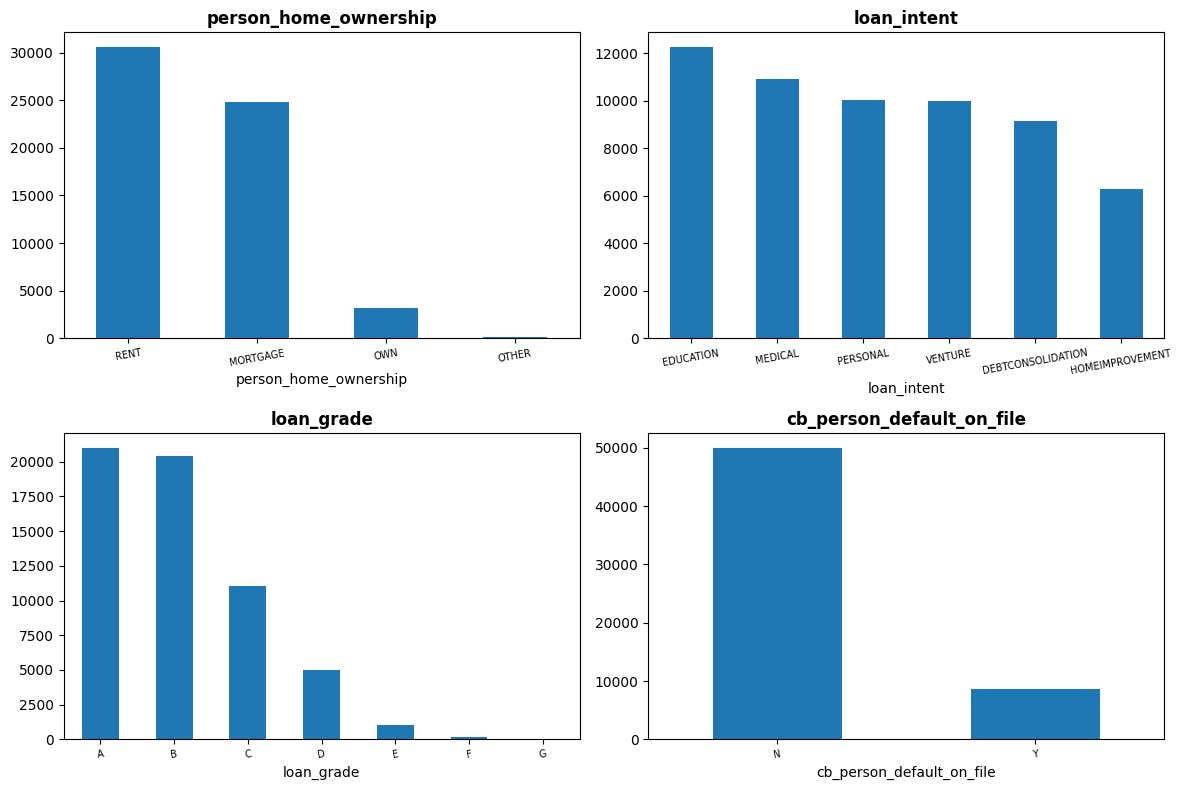

In [16]:
# @title 4.1 **Bar plot of Obj columns**
# Calculate the number of rows and columns for the grid
n_rows = 2
n_cols = 2

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))

# Iterate through the categorical columns and plot bar graphs
for i, col in enumerate(obj_cols):
    row = i // n_cols
    col_index = i % n_cols
    ax = axes[row, col_index]
    value_counts = train_df[col].value_counts()
    value_counts.plot(kind='bar', ax=ax)
    ax.set_title(col, fontweight='bold')
    # ax.set_xlabel(col)
    # ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=10, labelsize=7)  # Rotate x-axis labels

# for ax in axes.flatten():
#     for spine in ax.spines.values():
#         spine.set_visible(True)
#         spine.set_linewidth(2)  # Adjust linewidth as desired

plt.tight_layout()
plt.show()


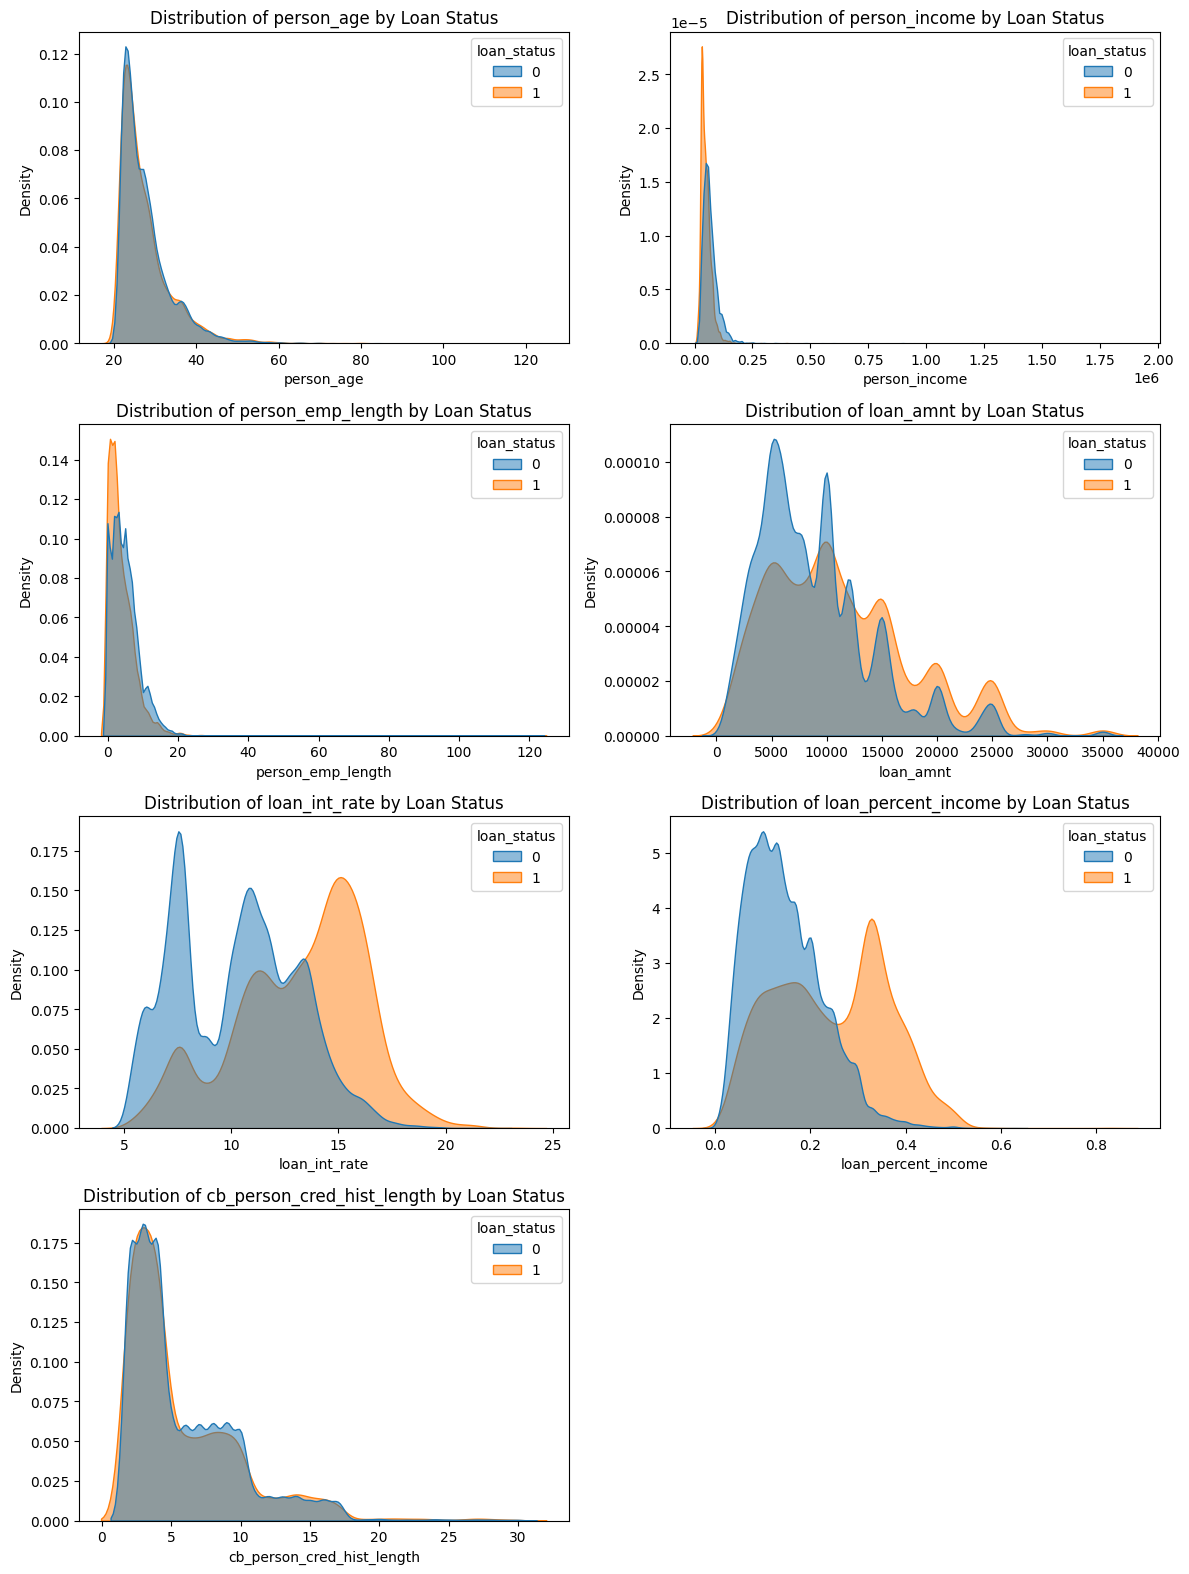

In [17]:
#@title 4.2 **Distribution of Numerical columns**

n_cols = 2
n_rows = (len(num_cols) + n_cols - 1) // n_cols


plt.figure(figsize=(12, 4 * n_rows))

for i, col in enumerate(num_cols, 1):
  if col != 'loan_status':
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(data=train_df, x=col, hue='loan_status', common_norm=False, fill=True, alpha=0.5)
    plt.title(f'Distribution of {col} by Loan Status')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


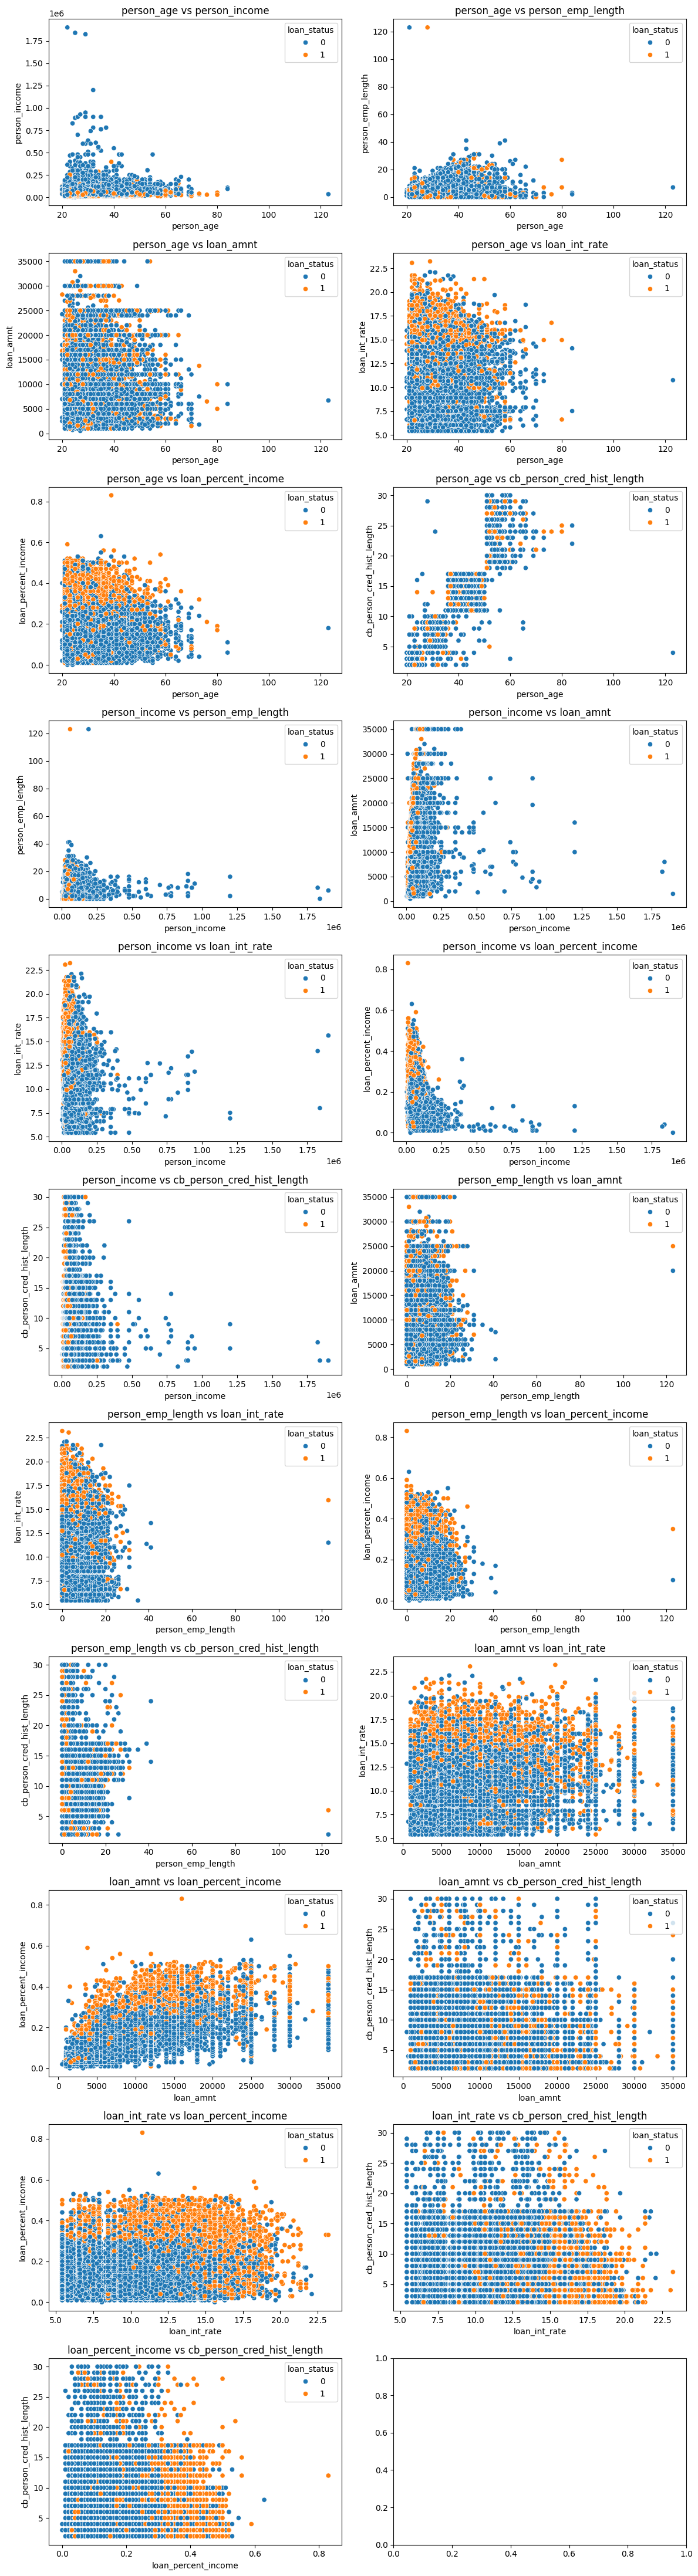

In [18]:
#@title 4.3 **Scatter plots**
import itertools

# Create a list of numerical columns excluding 'loan_status'
numerical_cols_for_scatter = [col for col in num_cols if col != 'loan_status']

# Create a list of all possible combinations of two numerical columns
combinations = list(itertools.combinations(numerical_cols_for_scatter, 2))

# Calculate the number of rows and columns for the grid based on the number of combinations
n_rows = (len(combinations) + 2 - 1) // 2
n_cols = 2


# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Iterate through the combinations and plot scatter plots
for i, (col1, col2) in enumerate(combinations):
  ax = axes[i]
  sns.scatterplot(x=train_df[col1], y=train_df[col2], hue=train_df['loan_status'], ax=ax)
  ax.set_title(f'{col1} vs {col2}')
  ax.set_xlabel(col1)
  ax.set_ylabel(col2)
  # ax.tick_params(axis='x', rotation=10, labelsize=7)


plt.tight_layout()
plt.show()


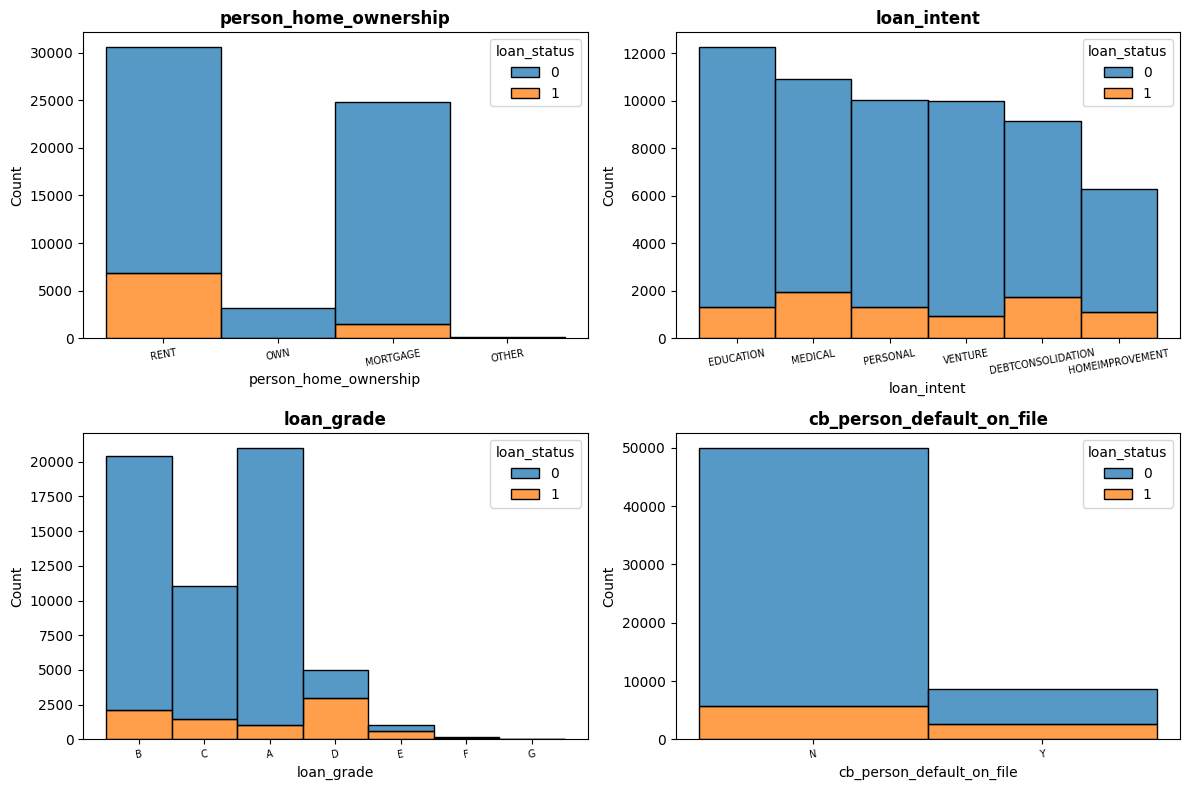

In [19]:
#@title 4.4 **Histogram of Obj columns based on Loan Status**

# Calculate the number of rows and columns for the grid
n_rows = 2
n_cols = 2

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))

# Iterate through the categorical columns and plot bar graphs
for i, col in enumerate(obj_cols):
    row = i // n_cols
    col_index = i % n_cols
    ax = axes[row, col_index]
    sns.histplot(data=train_df, x=col, hue='loan_status', multiple="stack", ax=ax)
    ax.set_title(col, fontweight='bold')
    ax.tick_params(axis='x', rotation=10, labelsize=7)

plt.tight_layout()
plt.show()


## *5. Feature Encoding and Correlation*

In [20]:
#@title 5.1 **Feature Encoding for Training set**
train_df['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}, inplace=True)
train_df['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}, inplace=True)
train_df['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}, inplace=True)
train_df['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}, inplace=True)

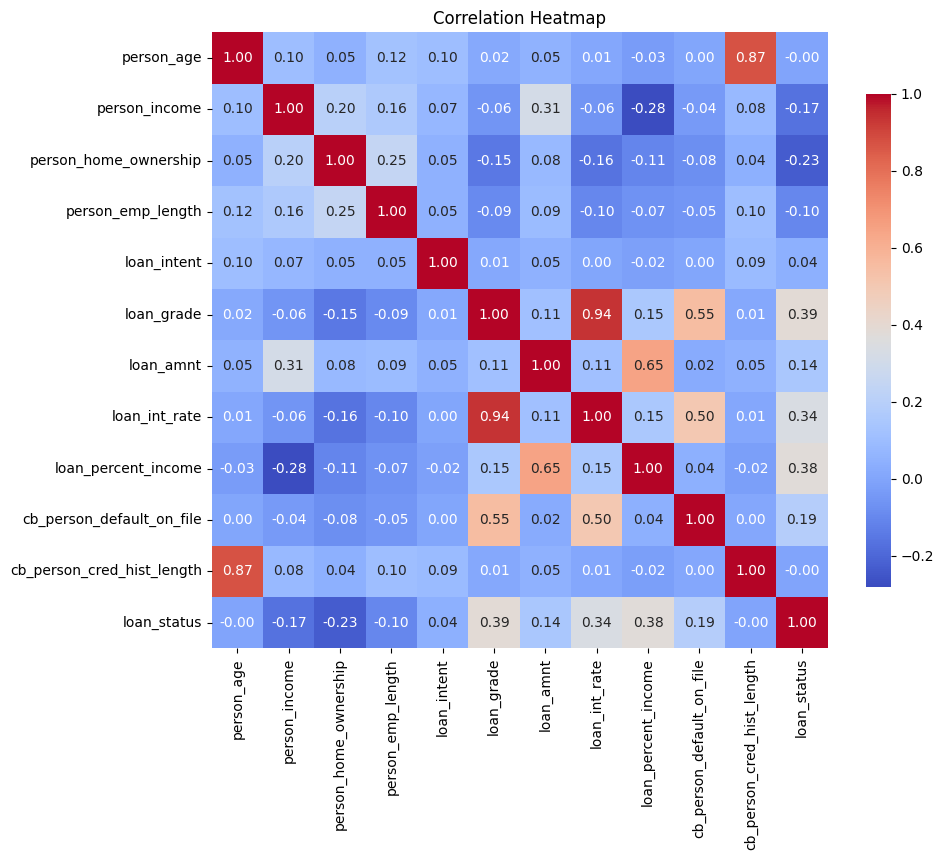

In [21]:
#@title 5.2 **Correlation**
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', fmt='.2f',
            square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')
plt.show()

In [22]:
#@title 5.3 **Feature Encoding for Testing set**
test_df['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}, inplace=True)
test_df['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}, inplace=True)
test_df['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}, inplace=True)
test_df['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}, inplace=True)

## *6. Outlier Detection*

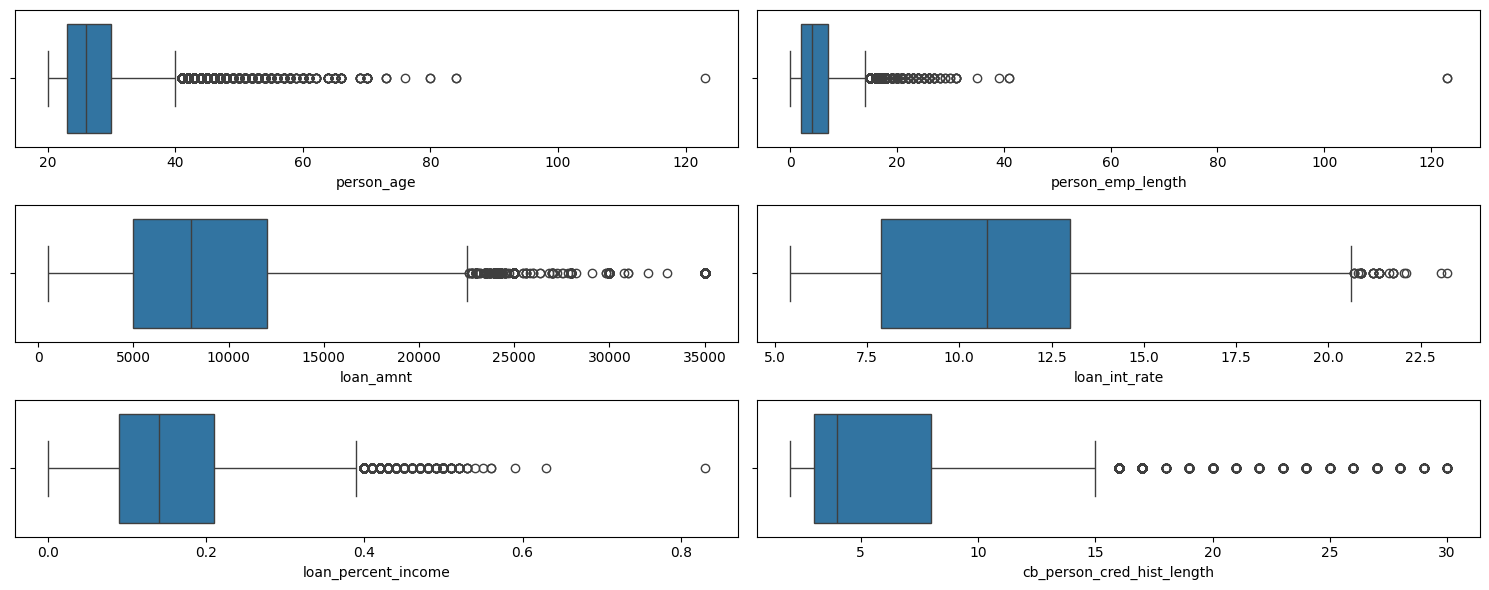

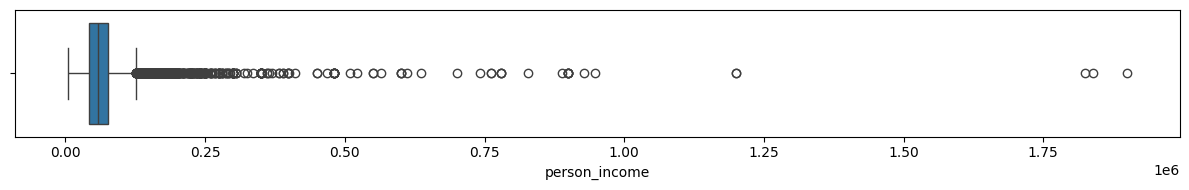

In [23]:
#@title 6.1 **Outlier detection using Box plot**

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 6))
axes = axes.flatten()

for i, col in enumerate(['person_age', 'person_emp_length', 'loan_amnt',
                         'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']):
    sns.boxplot(x=train_df[col], ax=axes[i])
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
sns.boxplot(x=train_df['person_income'])
plt.tight_layout()
plt.show()


### 6.2 **Removing descrepancy for Age and Emp length**

In [29]:
train_df = train_df[(train_df['person_age'] <= 100) & (train_df['person_emp_length'] <= 100)]

print("\nShape of modified Train df:", train_df.shape)
print(train_df['loan_status'].value_counts())


Shape of modified Train df: (58642, 12)
loan_status
0    50293
1     8349
Name: count, dtype: int64


## *7. Model Training*

In [30]:
# Define X (features) and y (target)
X = train_df.drop('loan_status', axis=1)
y = train_df['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (46913, 11)
X_test shape: (11729, 11)


In [32]:
# Initialize the scaler and scale the numerical features
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and testing sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### ML Model fitting and prediction

In [60]:
#@title Hyperparameter tuning for rf_model

from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, verbose=3, scoring=['accuracy', 'recall'], refit='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_best_rf = best_rf_model.predict(X_test_scaled)

# Evaluate the best model
print("Best Random Forest Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print(classification_report(y_test, y_pred_best_rf))

Fitting 5 folds for each of 48 candidates, totalling 240 fits

[CV 1/5] END max_depth=None, min_samples_split=2, n_estimators=50; accuracy: (test=0.950) recall: (test=0.718) total time=   2.7s

[CV 2/5] END max_depth=None, min_samples_split=2, n_estimators=50; accuracy: (test=0.953) recall: (test=0.724) total time=   2.4s

[CV 3/5] END max_depth=None, min_samples_split=2, n_estimators=50; accuracy: (test=0.951) recall: (test=0.711) total time=   3.4s

[CV 4/5] END max_depth=None, min_samples_split=2, n_estimators=50; accuracy: (test=0.947) recall: (test=0.703) total time=   2.3s

[CV 5/5] END max_depth=None, min_samples_split=2, n_estimators=50; accuracy: (test=0.948) recall: (test=0.703) total time=   2.3s

[CV 1/5] END max_depth=None, min_samples_split=2, n_estimators=100; accuracy: (test=0.950) recall: (test=0.718) total time=   4.6s

[CV 2/5] END max_depth=None, min_samples_split=2, n_estimators=100; accuracy: (test=0.954) recall: (test=0.726) total time=   5.9s

[CV 3/5] END max_d

In [34]:
#@title Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(max_depth= None, min_samples_split= 10, n_estimators= 200, random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf)

print("Random Forest Accuracy:", accuracy, "\n")
print(conf_matrix, "\n")
print(class_report)

Random Forest Accuracy: 0.9507204365248529 

[[9994  102]
 [ 476 1157]] 

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10096
           1       0.92      0.71      0.80      1633

    accuracy                           0.95     11729
   macro avg       0.94      0.85      0.89     11729
weighted avg       0.95      0.95      0.95     11729



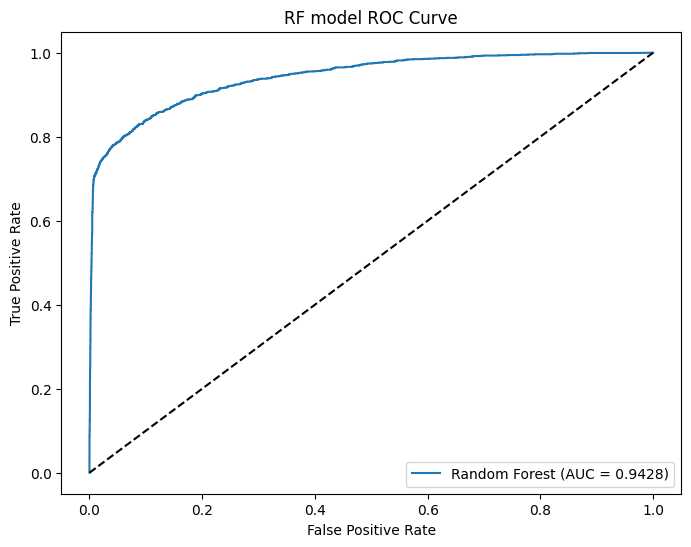

In [75]:
# Predict probabilities for the positive class
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.4f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF model ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [37]:
#@title XGB classifier
import xgboost as xgb

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgb)
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
class_report = classification_report(y_test, y_pred_xgb)

print("Accuracy:", accuracy, "\n")
print(conf_matrix, "\n")
print(class_report)

Accuracy: 0.9503794014835024 

[[9966  130]
 [ 452 1181]] 

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10096
           1       0.90      0.72      0.80      1633

    accuracy                           0.95     11729
   macro avg       0.93      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729



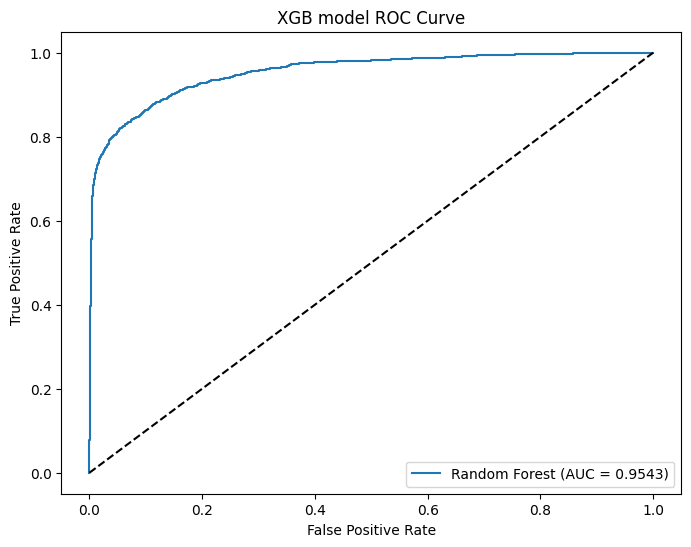

In [76]:
# Predict probabilities for the positive class
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve and AUC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label='Random Forest (AUC = %0.4f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB model ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [38]:
#@title Voting Classifier using rf and xgb
from sklearn.ensemble import VotingClassifier

# Create a voting classifier with Random Forest and XGBoost
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_ensemble = ensemble_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_ensemble)
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
class_report = classification_report(y_test, y_pred_ensemble)

print("Accuracy:", accuracy, "\n")
print(conf_matrix, "\n")
print(class_report)

Accuracy: 0.9514025066075539 

[[9990  106]
 [ 464 1169]] 

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10096
           1       0.92      0.72      0.80      1633

    accuracy                           0.95     11729
   macro avg       0.94      0.85      0.89     11729
weighted avg       0.95      0.95      0.95     11729



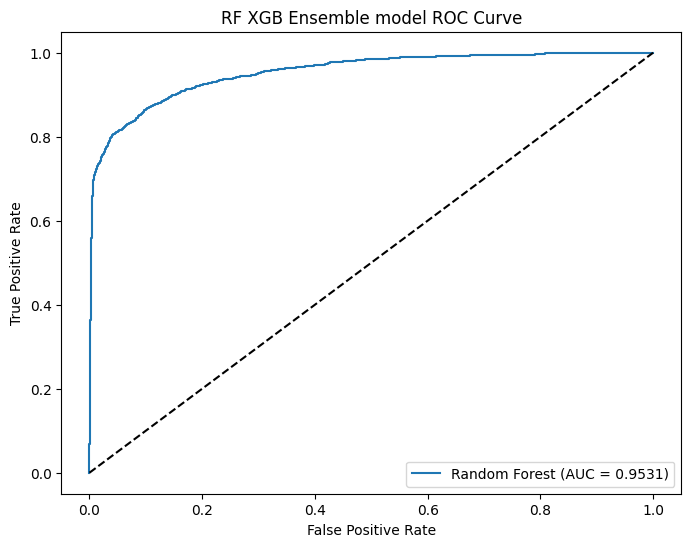

In [77]:
# Predict probabilities for the positive class
y_pred_proba_en1 = ensemble_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve and AUC
fpr_en1, tpr_en1, thresholds_en1 = roc_curve(y_test, y_pred_proba_en1)
roc_auc_en1 = roc_auc_score(y_test, y_pred_proba_en1)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_en1, tpr_en1, label='Random Forest (AUC = %0.4f)' % roc_auc_en1)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF XGB Ensemble model ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [66]:
#@title LightGB classifier

import lightgbm as lgb

# Initialize the LightGBM model
lgb_model = lgb.LGBMClassifier(n_estimators=150, objective='binary', learning_rate=0.05, random_state=42)

# Train the model
lgb_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_lgb)
conf_matrix = confusion_matrix(y_test, y_pred_lgb)
class_report = classification_report(y_test, y_pred_lgb)

print("Accuracy:", accuracy, "\n")
print(conf_matrix, "\n")
print(class_report)

[LightGBM] [Info] Number of positive: 6716, number of negative: 40197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 882
[LightGBM] [Info] Number of data points in the train set: 46913, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143159 -> initscore=-1.789300
[LightGBM] [Info] Start training from score -1.789300
Accuracy: 0.9520845766902549 

[[10000    96]
 [  466  1167]] 

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10096
           1       0.92      0.71      0.81      1633

    accuracy                           0.95     11729
   macro avg       0.94      0.85      0.89     11729
weighted avg       0.95      0.95      0.95     11729



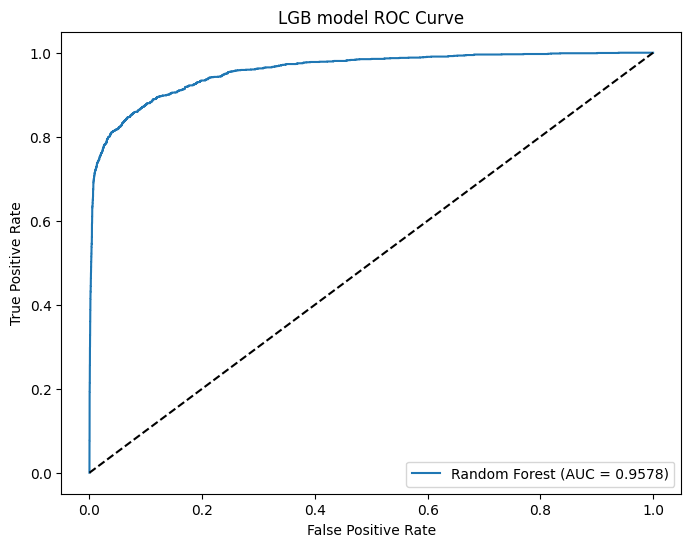

In [78]:
# Predict probabilities for the positive class
y_pred_proba_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve and AUC
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, y_pred_proba_lgb)
roc_auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb, tpr_lgb, label='Random Forest (AUC = %0.4f)' % roc_auc_lgb)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGB model ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [67]:
#@title voting classifier using rf xgb and lgb

# Create a voting classifier with Random Forest, XGBoost, and LightGBM
ensemble_model2 = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model), ('lgb', lgb_model)], voting='soft')

# Train the ensemble model
ensemble_model2.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_ensemble2 = ensemble_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_ensemble2)
conf_matrix = confusion_matrix(y_test, y_pred_ensemble2)
class_report = classification_report(y_test, y_pred_ensemble2)

print("Accuracy:", accuracy, "\n")
print(conf_matrix, "\n")
print(class_report)

[LightGBM] [Info] Number of positive: 6716, number of negative: 40197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 882
[LightGBM] [Info] Number of data points in the train set: 46913, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143159 -> initscore=-1.789300
[LightGBM] [Info] Start training from score -1.789300
Accuracy: 0.9514025066075539 

[[9990  106]
 [ 464 1169]] 

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10096
           1       0.92      0.72      0.80      1633

    accuracy                           0.95     11729
   macro avg       0.94      0.85      0.89     11729
weighted avg       0.95      0.95      0.95     11729



In [64]:
#@title CatBoostClassifier

from catboost import CatBoostClassifier

# Initialize the CatBoost model
catboost_model = CatBoostClassifier(iterations=150, learning_rate=0.08, depth=11, loss_function='Logloss', random_seed=42, verbose=0)


# Train the model
catboost_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_catboost = catboost_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_catboost)
conf_matrix = confusion_matrix(y_test, y_pred_catboost)
class_report = classification_report(y_test, y_pred_catboost)

print("Accuracy:", accuracy, "\n")
print(conf_matrix, "\n")
print(class_report)

Accuracy: 0.9526813880126183 

[[10005    91]
 [  464  1169]] 

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10096
           1       0.93      0.72      0.81      1633

    accuracy                           0.95     11729
   macro avg       0.94      0.85      0.89     11729
weighted avg       0.95      0.95      0.95     11729



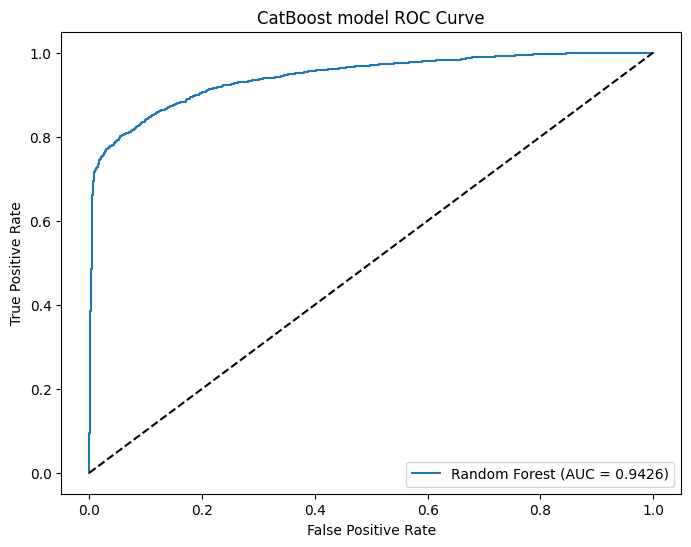

In [79]:
# Predict probabilities for the positive class
y_pred_proba_catboost = catboost_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve and AUC
fpr_catboost, tpr_catboost, thresholds_catboost = roc_curve(y_test, y_pred_proba_catboost)
roc_auc_catboost = roc_auc_score(y_test, y_pred_proba_catboost)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, label='Random Forest (AUC = %0.4f)' % roc_auc_catboost)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CatBoost model ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [69]:
#@title voting classifier using lgb and catboost

# Create a voting classifier with Random Forest, XGBoost, and LightGBM
ensemble_model3 = VotingClassifier(estimators=[('lgb', lgb_model), ('cat', catboost_model)], voting='soft')

# Train the ensemble model
ensemble_model3.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_ensemble3 = ensemble_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_ensemble3)
conf_matrix = confusion_matrix(y_test, y_pred_ensemble3)
class_report = classification_report(y_test, y_pred_ensemble3)

print("Accuracy:", accuracy, "\n")
print(conf_matrix, "\n")
print(class_report)

[LightGBM] [Info] Number of positive: 6716, number of negative: 40197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 882
[LightGBM] [Info] Number of data points in the train set: 46913, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143159 -> initscore=-1.789300
[LightGBM] [Info] Start training from score -1.789300
Accuracy: 0.9514025066075539 

[[9990  106]
 [ 464 1169]] 

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10096
           1       0.92      0.72      0.80      1633

    accuracy                           0.95     11729
   macro avg       0.94      0.85      0.89     11729
weighted avg       0.95      0.95      0.95     11729



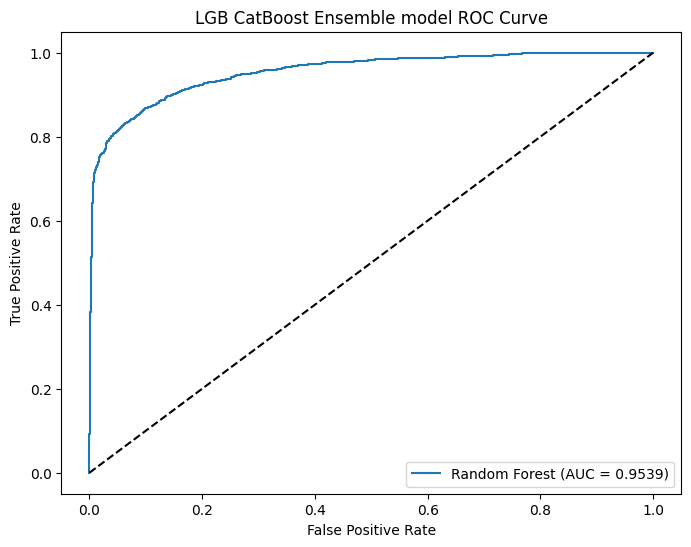

In [80]:
# Predict probabilities for the positive class
y_pred_proba_en3 = ensemble_model3.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve and AUC
fpr_en3, tpr_en3, thresholds_en3 = roc_curve(y_test, y_pred_proba_en3)
roc_auc_en3 = roc_auc_score(y_test, y_pred_proba_en3)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_en3, tpr_en3, label='Random Forest (AUC = %0.4f)' % roc_auc_en3)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGB CatBoost Ensemble model ROC Curve')
plt.legend(loc='lower right')
plt.show()

# *8. Model Testing*

In [70]:
train_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,0,0.0,0,1,6000,11.49,0.17,0,14,0
1,22,56000,2,6.0,1,2,4000,13.35,0.07,0,2,0
2,29,28800,2,8.0,2,0,6000,8.90,0.21,0,10,0
3,30,70000,0,14.0,3,1,12000,11.11,0.17,0,5,0
4,22,60000,0,2.0,1,0,6000,6.92,0.10,0,3,0


In [71]:
test_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,0,3.0,5,5,25000,15.76,0.36,0,2
58646,26,96000,1,6.0,2,2,10000,12.68,0.10,1,4
58647,26,30000,0,5.0,3,4,4000,17.19,0.13,1,2
58648,33,50000,0,4.0,4,0,7000,8.90,0.14,0,7
58649,26,102000,1,8.0,5,3,15000,16.32,0.15,1,4


In [72]:
# Scaling test dataset
test_df_scaled = scaler.transform(test_df)

## Submitting using LGB model

In [87]:
predictions = lgb_model.predict_proba(test_df_scaled)[:,1]  # Replace rf_model with your desired model
submission_df = pd.DataFrame({'id': test_df.index, 'loan_status': predictions}) #.set_index('id')
submission_df

,id,loan_status
0,58645,0.984801
1,58646,0.015518
2,58647,0.517318
3,58648,0.014199
4,58649,0.116679
...,...,...
39093,97738,0.077380
39094,97739,0.008865
39095,97740,0.014862
39096,97741,0.325653


In [88]:
submission_df.to_csv('submission.csv', index=False)

In [86]:
submission_df.shape

(39098, 1)